# Text Analysis
---

## Introduction

**Text analysis** is used to extract useful information from or summarize a large amount of unstructured text stored in documents. This opens up the opportunity of using text data alongside more conventional data sources (e.g. surveys and administrative data). The goal of text analysis is to take a large corpus of complex and unstructured text data and extract important and meaningful messages in a comprehensible way. 

Text analysis can help with the following tasks:

* **Information Retrieval**: Find relevant information in a large database, such as a systematic literature review, that would be very time-consuming for humans to do manually. 

* **Clustering and Text Categorization**: Summarize a large corpus of text by finding the most important phrases, using methods like topic modeling. 

* **Text Summarization**: Create category-sensitive text summaries of a large corpus of text. 

* **Machine Translation**: Translate documents from one language to another. 

In this tutorial, we are going to analyze social services descriptions using topic modeling to examine the content of our data and document classification to tag the type of job in the advertisement. 

## Learning Outcomes
In this tutorial, you will...
* Learn how to transform a corpus of text into a structured matrix format so that we can apply natural language processing (NLP) methods
* Learn the basics and applications of topic modeling
* Learn how to do document tagging and evaluate the results

 
## Glossary of Terms

* **Corpus**: A corpus is the set of all text documents used in your analysis; for example, your corpus of text may include hundreds of research articles.

* **Tokenize**: Tokenization is the process by which text is separated into meaningful terms or phrases. In English this is easy to do for individual words, as they are separated by whitespace; however, it can get more complicated to  automate determining which groups of words constitute meaningful phrases. 

* **Stemming**: Stemming is normalizing text by reducing all forms or conjugations of a word to the word's most basic form. In English, this can mean making a rule of removing the suffixes "ed" or "ing" from the end of all words, but it gets more complex. For example, "to go" is irregular, so you need to tell the algorithm that "went" and "goes" stem from a common lemma, and should be considered alternate forms of the word "go."

* **TF-IDF**: TF-IDF (term frequency-inverse document frequency) is an example of feature engineering where the most important words are extracted by taking account their frequency in documents and the entire corpus of documents as a whole.

* **Topic Modeling**: Topic modeling is an unsupervised learning method where groups of words that often appear together are clustered into topics. Typically, the words in one topic should be related and make sense (e.g. boat, ship, captain). Individual documents can fall under one topic or multiple topics. 

* **LDA**: LDA (Latent Dirichlet Allocation) is a type of probabilistic model commonly used for topic modeling. 

* **Stop Words**: Stop words are words that have little semantic meaning but occur very frequently, like prepositions, articles and common nouns. For example, every document (in English) will probably contain the words "and" and "the" many times. You will often remove them as part of preprocessing using a list of stop words.


In [2]:
%pylab inline 
import nltk
import ujson
import re
import time
import progressbar

import pandas as pd
from __future__ import print_function
from six.moves import zip, range 
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn import preprocessing
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk import SnowballStemmer

Populating the interactive namespace from numpy and matplotlib


In [3]:
nltk.download('stopwords') #download the latest stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ellio\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

# Load the Data

Our dataset for this tutorial will be a description of social services in Chicago, and how the subset we're using was created, can be found in the `data` folder in this tutorial.

In [4]:
df_socialservices_data = pd.read_csv('./data/socialservices.csv')

# Explore the Data 

In [5]:
df_socialservices_data.head()

,Unnamed: 0,FACID,facname,factype,facurl,facloc,abouturl,textfromurl
0,0,2,Association House of Chicago,education,http://www.associationhouse.org/,Metro,http://www.associationhouse.org/home/about-us/,Menu About Us We understand the challenges in ...
1,1,3,"Aunt Martha’s Youth Service Center, Inc.",education,http://www.auntmarthas.org,"Metro, North-Northwest, South-Southwest",https://www.auntmarthas.org/mission-vision-val...,"Mission, Vision & Core Values OUR MISSION A c..."
2,2,3,"Aunt Martha’s Youth Service Center, Inc.",education,http://www.auntmarthas.org,"Metro, North-Northwest, South-Southwest",https://www.auntmarthas.org/who-we-are/,Who We Are Aunt Martha’s is a family of more t...
3,3,4,"B.U.I.L.D., Inc.",education,http://www.buildchicago.org/,Metro,http://www.buildchicago.org/about-us,"About Us Since 1969, BUILD (Broader Urban Invo..."
4,4,4,"B.U.I.L.D., Inc.",education,http://www.buildchicago.org/,Metro,http://www.buildchicago.org/building-futures,BUILDing Futures: College Access and Career Re...


Our table has 7 fields: `FACID`, `facname`, `factype`, `facurl`, `facloc`, `abouturl`, and `textfromurl`. 

### How many facilities and types of facilities are in this dataset?

In [11]:
df_socialservices_data.factype.unique()

array(['education', 'income', 'health', 'safety net'], dtype=object)

In [12]:
df_socialservices_data.facname.unique()

array(['Association House of Chicago',
       'Aunt Martha’s Youth Service Center, Inc.', 'B.U.I.L.D., Inc.',
       'Catholic Charities of the Archdiocese of Chicago',
       'Chinese American Service League', 'The Community House',
       'Family Focus Inc.', 'Infant Welfare Society of Evanston',
       'Lawrence Hall Youth Services', 'Project: VISION, Inc.',
       'The Chicago Lighthouse for People Who Are Blind or Visually Impaired',
       'YMCA of Metropolitan Chicago', 'Youth Crossroads, Inc.',
       'Youth Guidance', 'Center for Economic Progress',
       'Chicago House and Social Service Agency', 'Clearbrook',
       'DuPage PADS', 'Family Shelter Service, Inc.',
       'Heartland Human Care Services, Inc.', 'Inspiration Corporation',
       'Ladder Up', 'Little City Foundation',
       'Lutheran Child and Family Services of Illinois',
       'National Able Network, Inc', 'North Lawndale Employment Network',
       'People’s Resource Center', 'PLOWS Council on Aging',
      

In [13]:
df_socialservices_data.facname.unique().shape

(48,)

There are 48 facilities, categorized into 4 unique facility types: education, income, health, and safety net. 



# Topic Modeling

We are going to apply topic modeling, an unsupervised learning method, to our corpus to find the high-level topics in our corpus as a "first go" for exploring our data. Through this process, we'll discuss how to clean and preprocess our data to get the best results.

Topic modeling is a broad subfield of machine learning and natural language processing. We are going to focus on a common modeling approach called Latent Dirichlet Allocation (LDA). 

To use topic modeling, we first have to assume that topics exist in our corpus, and that some small number of these topics can "explain" the corpus. Topics in this context refer to words from the corpus, in a list that is ranked by probability. A single document can be explained by multiple topics. For instance, an article on net neutrality would fall under the topic "technology" as well as the topic "politics." The set of topics used by a document is known as the document's allocation, hence, the name Latent Dirchlet Allocation, each document has an allocation of latent topics allocated by Dirchlet distribution. 

## Processing Text Data

The first important step in working with text data is cleaning and processing the data, which includes (but is not limited to) *forming a corpus of text, tokenization, removing stop-words, finding words co-located together (N-grams), and stemming and lemmatization*. Each of these steps will be discussed below. 

The ultimate goal is to transform our text data into a form an algorithm can work with, because a document or a corpus of text cannot be fed directly into an algorithm. Algorithms expect numerical feature vectors with certain fixed sizes, and can't handle documents, which are basically sequences of symbols with variable length. We will be transforming our text corpus into a *bag of n-grams* to be further analyzed. In this form our text data is represented as a matrix where each row refers to a specific job description (document) and each column is the occurence of a word (feature).


### Bag of N-gram Representation Example

Ultimately, we want to take our collection of documents, corpus, and convert it into a matrix. Fortunately, `sklearn` has a pre-built object, `CountVectorizer`, that can tokenize, eliminate stopwords, identify n-grams, and stem our corpus, and output a matrix in one step. Before we apply the vectorizer to our corpus of data, let's apply it to a toy example so that we see what the output looks like and how a bag of words is represented. 

In [14]:
def create_bag_of_words(corpus,
                       NGRAM_RANGE=(0,1),
                       stop_words = None,
                        stem = False,
                       MIN_DF = 0.05,
                       MAX_DF = 0.95,
                       USE_IDF=False):
    """
    Turn a corpus of text into a bag-of-words.
    
    Parameters
    -----------
    corpus: ls
        test of documents in corpus    
    NGRAM_RANGE: tuple
        range of N-gram. Default (0,1)
    stop_words: ls
        list of commonly occuring words that have little semantic
        value
    stem: bool
        use a stemmer to stem words
    MIN_DF: float
       exclude words that have a frequency less than the threshold
    MAX_DF: float
        exclude words that have a frequency greater than the threshold
    
    
    Returns
    -------
    bag_of_words: scipy sparse matrix
        scipy sparse matrix of text
    features:
        ls of words
    """
    #parameters for vectorizer 
    ANALYZER = "word" #unit of features are single words rather then phrases of words 
    STRIP_ACCENTS = 'unicode'
    stemmer = nltk.SnowballStemmer("english")

    if stem:
        tokenize = lambda x: [stemmer.stem(i) for i in x.split()]
    else:
        tokenize = None
    vectorizer = CountVectorizer(analyzer=ANALYZER,
                                tokenizer=tokenize, 
                                ngram_range=NGRAM_RANGE,
                                stop_words = stop_words,
                                strip_accents=STRIP_ACCENTS,
                                min_df = MIN_DF,
                                max_df = MAX_DF)
    
    bag_of_words = vectorizer.fit_transform( corpus ) #transform our corpus is a bag of words 
    features = vectorizer.get_feature_names()

    if USE_IDF:
        NORM = None #turn on normalization flag
        SMOOTH_IDF = True #prvents division by zero errors
        SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
        transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)
        #get the bag-of-words from the vectorizer and
        #then use TFIDF to limit the tokens found throughout the text 
        tfidf = transformer.fit_transform(bag_of_words)
        
        return tfidf, features
    else:
        return bag_of_words, features

In [15]:
toy_corpus = ['this is document one', 'this is document two', 'text analysis on documents is fun'] 

In [16]:
toy_bag_of_words, toy_features = create_bag_of_words(toy_corpus)

In [17]:
toy_corpus

['this is document one',
 'this is document two',
 'text analysis on documents is fun']

In [18]:
toy_features

['analysis',
 'document',
 'documents',
 'fun',
 'on',
 'one',
 'text',
 'this',
 'two']

In [19]:
np_bag_of_words = toy_bag_of_words.toarray()
np_bag_of_words

array([[0, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 1, 1, 1, 0, 1, 0, 0]], dtype=int64)

In [23]:
toy_bag_of_words.

TypeError: 'numpy.ndarray' object is not callable

Our data has been transformed from a document into a 3 x 9 matrix, where each row in the matrix corresponds to a document, and each column corresponds to a feature (in the order they appear in `toy_features`). A 1 indicates the existence of the feature or word in the document, and a 0 indicates the word is not present.

It is very common that this representation will be a "sparse" matrix, or a matrix that has a lot of 0s. With sparse matrices, it is often more efficient to keep track of which values *aren't* 0 and where those non-zero entries are located, rather than to save the entire matrix. To save space, the `scipy` library has special ways of storing sparse matrices in an efficient way. 

Our toy corpus is now ready to be analyzed. We used this toy example to illustrate how a document is turned into a matrix to be used in text analysis. When you're applying this to real text data, the matrix will be much larger and harder to interpret, but it's important that you know the process. 

---
## Exercise 1 

To check your knowledge, make your own toy corpus and turn it into a matrix.

In [24]:
#solution
exercise_corpus = ['Batman is friends with Superman', 
                   'Superman is enemies with Lex Luthor',
                   'Batman is enemies with Lex Luthor'] 
exercise_bag_of_words, exercise_features = create_bag_of_words(exercise_corpus)

In [25]:
np_bag_of_words = exercise_bag_of_words.toarray()

In [26]:
exercise_features

['batman', 'enemies', 'friends', 'lex', 'luthor', 'superman']

In [27]:
np_bag_of_words

array([[1, 0, 1, 0, 0, 1],
       [0, 1, 0, 1, 1, 1],
       [1, 1, 0, 1, 1, 0]], dtype=int64)

In [28]:
pd.DataFrame(data=np_bag_of_words, columns=exercise_features)

,batman,enemies,friends,lex,luthor,superman
0,1,0,1,0,0,1
1,0,1,0,1,1,1
2,1,1,0,1,1,0


In [29]:
exercise_bag_of_words_tf, exercise_features_tf = create_bag_of_words(exercise_corpus, USE_IDF=True)
np_bag_of_words_tf = exercise_bag_of_words_tf.toarray()
pd.DataFrame(data=np_bag_of_words_tf, columns=exercise_features_tf)

,batman,enemies,friends,lex,luthor,superman
0,1.287682,0.000000,1.693147,0.000000,0.000000,1.287682
1,0.000000,1.287682,0.000000,1.287682,1.287682,1.287682
2,1.287682,1.287682,0.000000,1.287682,1.287682,0.000000


---

## Word Counts

As an initial look into the data, we can examine the most frequently occuring words in our corpus. We can sum the columns of the bag_of_words and then convert to a numpy array. From here we can zip the features and word_count into a dictionary, and display the results.

In [38]:
def get_word_counts(bag_of_words, feature_names):
    """
    Get the ordered word counts from a bag_of_words
    
    Parameters
    ----------
    bag_of_words: obj
        scipy sparse matrix from CounterVectorizer
    feature_names: ls
        list of words
        
    Returns
    -------
    word_counts: dict
        Dictionary of word counts
    """
    np_bag_of_words = bag_of_words.toarray()
    word_count = np.sum(np_bag_of_words,axis=0)
    np_word_count = np.asarray(word_count).ravel()
    dict_word_counts = dict( zip(feature_names, np_word_count) )
    
    orddict_word_counts = OrderedDict( 
                                    sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )
    print(sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True))

    return orddict_word_counts

In [39]:
get_word_counts(toy_bag_of_words, toy_features)

[('document', 2), ('this', 2), ('analysis', 1), ('documents', 1), ('fun', 1), ('on', 1), ('one', 1), ('text', 1), ('two', 1)]


OrderedDict([('document', 2),
             ('this', 2),
             ('analysis', 1),
             ('documents', 1),
             ('fun', 1),
             ('on', 1),
             ('one', 1),
             ('text', 1),
             ('two', 1)])

Note that the words "document" and "documents" both appear separately in the list. Should they be treated as the same words, since one is just the plural of the other, or should they be considered distinct words? These are the types of decisions you will have to make in your preprocessing steps.

---
## Exercise 2 

Get the word counts of your exercise corpus.


In [40]:
get_word_counts(exercise_bag_of_words, exercise_features)

[('batman', 2), ('enemies', 2), ('lex', 2), ('luthor', 2), ('superman', 2), ('friends', 1)]


OrderedDict([('batman', 2),
             ('enemies', 2),
             ('lex', 2),
             ('luthor', 2),
             ('superman', 2),
             ('friends', 1)])

### Text Corpora

First we need to form our corpus, or the set of all descriptions from all websites. We can pull out the array of descriptions from the data frame using the data frame's `.values` attribute. 

In [41]:
corpus = df_socialservices_data['textfromurl'].values #pull all the descriptions and put them in a numpy array 
corpus

array(['Menu About Us We understand the challenges in our community. Health care, family, education, employment; trying to find the time and guidance to address every part of life can seem impossible. Association House makes it possible, all in one place — a place where the staff speaks your language and helps you meet your goals by providing wrap-around services for social, educational, and health programs. We offer our community a unique blend of services, and do it with a warm, family-like atmosphere. Since 1899, Association House has worked with Chicagoans who seek tools to lead more productive lives. It is one of the oldest “settlement houses” in Chicago originally designed to provide relief and guidance to new immigrants. Today, Association House is a vital resource to under-served, multicultural communities, providing collaborative programs in English and Spanish. We promote health and wellness, educational advancement, and economic empowerment. With a staff of over 200 professi

In [89]:
def create_topics(tfidf, features, N_TOPICS=3, N_TOP_WORDS=5,):
    """
    Given a matrix of features of text data generate topics
    
    Parameters
    -----------
    tfidf: scipy sparse matrix
        sparse matrix of text features
    N_TOPICS: int
        number of topics (default 10)
    N_TOP_WORDS: int
        number of top words to display in each topic (default 10)
        
    Returns
    -------
    ls_keywords: ls
        list of keywords for each topics
    doctopic: array
        numpy array with percentages of topic that fit each category
    N_TOPICS: int
        number of assumed topics
    N_TOP_WORDS: int
        Number of top words in a given topic. 
    """
    
#    with progressbar.ProgressBar(maxval=progressbar.UnknownLength) as bar:
    
    bar = progressbar.ProgressBar()
    bar.start()
    i=0
    lda = LatentDirichletAllocation(n_components= N_TOPICS,
                                    learning_method='online') #create an object that will create 5 topics
    bar.update(i)
    i+=1
    doctopic = lda.fit_transform( tfidf )
    bar.update(i)
    i+=1
    
        
    ls_keywords = []
    for i,topic in enumerate(lda.components_):
        word_idx = np.argsort(topic)[::-1][:N_TOP_WORDS]
        keywords = ', '.join( features[i] for i in word_idx)
        ls_keywords.append(keywords)
        print(i, keywords)
        bar.update(i)
        i+=1
    
    bar.finish()
    
    return ls_keywords, doctopic

In [43]:
corpus_bag_of_words, corpus_features = create_bag_of_words(corpus)

Let's examine our features. 

In [44]:
corpus_features

['000',
 '0x',
 '10',
 '11',
 '12',
 '1215',
 '13',
 '1300',
 '15',
 '150',
 '16',
 '17',
 '18',
 '1868',
 '20',
 '2000',
 '2005',
 '2011',
 '2013',
 '2014',
 '2016',
 '2017',
 '208',
 '24',
 '25',
 '28',
 '30',
 '312',
 '360',
 '40',
 '400',
 '500',
 '501',
 '60201',
 '60604',
 '630',
 '660',
 '708',
 '718',
 '800',
 '8445',
 '847',
 '8498',
 '864',
 '877',
 'able',
 'about',
 'abuse',
 'academic',
 'accepted',
 'access',
 'achieve',
 'across',
 'action',
 'activities',
 'addition',
 'additional',
 'address',
 'administrative',
 'adults',
 'advances',
 'advisory',
 'advocacy',
 'advocate',
 'advocates',
 'after',
 'age',
 'aged',
 'agency',
 'ages',
 'aid',
 'all',
 'alliance',
 'also',
 'always',
 'american',
 'an',
 'and',
 'annual',
 'annually',
 'another',
 'any',
 'anyone',
 'april',
 'are',
 'area',
 'areas',
 'around',
 'array',
 'art',
 'arts',
 'as',
 'assets',
 'assist',
 'assistance',
 'association',
 'at',
 'attorney',
 'attorneys',
 'available',
 'back',
 'background',
 '

The first aspect to notice about the feature list is that the first few entries are numbers that have no real semantic meaning. The feature lists also includes numerous other useless words, such as prepositions and articles, that will just add noise to our analysis. 

We can also notice the words *action* and *activities*, or the words *addition* and *additional*, are close enough to each other that it might not make sense to treat them as entirely separate words. Part of your cleaning and preprocessing duties will be manually inspecting your lists of features, seeing where these issues arise, and making decisions to either remove them from your analysis or address them separately. 

Let's get the count of the number of times that each of the words appears in our corpus.

In [45]:
get_word_counts(corpus_bag_of_words, corpus_features)

[('and', 1857), ('the', 1745), ('to', 1360), ('of', 1231), ('in', 930), ('our', 651), ('for', 581), ('we', 491), ('services', 474), ('is', 440), ('with', 337), ('on', 320), ('that', 301), ('click', 290), ('youth', 286), ('are', 284), ('community', 269), ('us', 261), ('chicago', 241), ('you', 233), ('mission', 226), ('as', 225), ('or', 221), ('more', 220), ('by', 219), ('about', 208), ('their', 194), ('at', 193), ('function', 180), ('your', 180), ('all', 173), ('support', 162), ('event', 151), ('family', 150), ('programs', 149), ('send', 147), ('from', 146), ('program', 143), ('who', 139), ('housing', 138), ('ga', 136), ('an', 133), ('families', 131), ('if', 123), ('have', 122), ('be', 121), ('people', 121), ('center', 115), ('life', 115), ('catholic', 112), ('help', 109), ('it', 109), ('has', 107), ('social', 106), ('through', 101), ('communities', 100), ('care', 96), ('illinois', 94), ('house', 93), ('can', 92), ('charities', 92), ('vision', 92), ('clients', 91), ('service', 91), ('co

OrderedDict([('and', 1857),
             ('the', 1745),
             ('to', 1360),
             ('of', 1231),
             ('in', 930),
             ('our', 651),
             ('for', 581),
             ('we', 491),
             ('services', 474),
             ('is', 440),
             ('with', 337),
             ('on', 320),
             ('that', 301),
             ('click', 290),
             ('youth', 286),
             ('are', 284),
             ('community', 269),
             ('us', 261),
             ('chicago', 241),
             ('you', 233),
             ('mission', 226),
             ('as', 225),
             ('or', 221),
             ('more', 220),
             ('by', 219),
             ('about', 208),
             ('their', 194),
             ('at', 193),
             ('function', 180),
             ('your', 180),
             ('all', 173),
             ('support', 162),
             ('event', 151),
             ('family', 150),
             ('programs', 149),
            

Our top words are articles, prepositions and conjunctions that are not informative whatsoever, so we're probably not going to come up with anything interesting ("garbage in, garbage out"). 

Nevertheless, let's forge blindly ahead and try to create topics, and see the quality of the results that we get.

In [93]:
ls_corpus_keywords, corpus_doctopic = create_topics(corpus_bag_of_words, corpus_features)

0 the, and, to, of, in
1 and, the, evanston, ywca, north
2 and, the, to, of, in


In [73]:
corpus_doctopic

array([[3.38545412e-01, 1.55239945e-01, 5.06214643e-01],
       [6.40995627e-02, 2.97377056e-03, 9.32926667e-01],
       [6.88148394e-02, 2.71889060e-03, 9.28466270e-01],
       [3.54144877e-01, 1.61115594e-03, 6.44243967e-01],
       [1.94814115e-01, 1.44080631e-03, 8.03745079e-01],
       [1.02240720e-01, 1.71039446e-03, 8.96048886e-01],
       [6.27266046e-01, 2.21187044e-01, 1.51546910e-01],
       [3.39135238e-02, 3.22914344e-02, 9.33795042e-01],
       [9.64061615e-02, 9.41563152e-04, 9.02652275e-01],
       [2.32191483e-01, 1.98927269e-03, 7.65819245e-01],
       [1.98357607e-03, 2.00723685e-03, 9.96009187e-01],
       [1.98801711e-03, 2.01405111e-03, 9.95997932e-01],
       [2.93462102e-01, 1.28581353e-01, 5.77956545e-01],
       [3.80647977e-01, 1.08392644e-01, 5.10959379e-01],
       [1.23475390e-01, 6.66554556e-03, 8.69859064e-01],
       [6.14176367e-02, 8.33586603e-02, 8.55223703e-01],
       [2.49227399e-03, 1.92372518e-01, 8.05135208e-01],
       [2.12300899e-03, 2.07368

These topics don't give us any real insight to what the data contains - one of the topics is "and, the, to, of, in"! There are some hints to the subjects of the websites ("YWCA", "youth") and their locations ("Evanston"), but the signal is being swamped by the noise. 

The word "click" also comes up. This word might be useful in some contexts, but since we scraped this data from websites, it's likely that "click" is more related to the website itself (e.g. "Click here to find out more") as opposed to the content of the website. 

We'll have to clean and process our data to get any meaningful information out of this text. 

### Text Cleaning and Normalization

To clean and normalize text, we'll remove all special characters, numbers, and punctuation, so we're left with only the words themselves. Then we will make all the text lowercase; this uniformity will ensure that the algorithm doesn't treat "the" and "The" as different words, for example. 

To remove the special characters, numbers and punctuation we will use regular expressions. 


**Regular Expressions**, or "regexes" for short, let you find all the words or phrases in a document or text file that match a certain pattern. These rules are useful for pulling out useful information from a large amount of text. For example, if you want to find all email addresses in a document, you might look for everything that looks like *some combination of letters, _, .* followed by *@*, followed by more letters, and ending in *.com* or *.edu*. If you want to find all the credit card numbers in a document, you might look for everywhere you see the pattern "four numbers, space, four numbers, space, four numbers, space, four numbers." Regexes are also helpful if you are scraping information from websites, because you can use them to separate the content from the HTML code used for formatting the website.

A full tutorial on regular expressions would be outside the scope of this tutorial, but many good tutorials that can be found on-line. [regex101.com](regex101.com) is also a great interactive tool for developing and checking regular expressions.

>"Some people, when confronted with a problem, think 
>'I know, I'll use regular expressions.'   Now they have two problems."
> -- Jaime Zawinski

*A word of warning:* Regexes can work much more quickly than plain text sorting; however, if your regular expressions are becoming overly complicated, it's a good idea to find a simpler way to do what you want to do. Any developer should keep in mind there is a trade-off between optimization and understandability. The general philosophy of programming in Python is that your code is meant to be as understandable by *people* as much as possible, because human time is more valuable than computer time. You should therefore lean toward understandability rather than overly optimizing your code to make it run as quickly as possible. Your future-self, code-reviewers, people who inherit your code, and anyone else who has to make sense of your code in the future will appreciate it. 

For our purposes, we are going to use a regular expression to match all characters that are not letters -- punctuation, quotes, special characters and numbers -- and replace them with spaces. Then we'll make all of the remaining characters lowercase.  

We will be using the `re` library in python for regular expression matching.

In [74]:
#get rid of the punctuations and set all characters to lowercase
RE_PREPROCESS = r'\W+|\d+' #the regular expressions that matches all non-characters

#get rid of punctuation and make everything lowercase
#the code below works by looping through the array of text ("corpus")
#for a given piece of text ("comment") we invoke the `re.sub` command 
#the `re.sub` command takes 3 arguments: (1) the regular expression to match, 
#(2) what we want to substitute in place of that matching string (' ', a space)
#and (3) the text we want to apply this to. 
#we then invoke the `lower()` method on the output of the `re.sub` command
#to make all the remaining characters lowercase.
#the result is a list, where each entry in the list is a cleaned version of the
#corresponding entry in the original corpus.
#we then make the list into a numpy array to use it in analysis

processed_corpus = np.array( [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in corpus] )

#### First Description, Before Cleaning

In [75]:
corpus[0]

'Menu About Us We understand the challenges in our community. Health care, family, education, employment; trying to find the time and guidance to address every part of life can seem impossible. Association House makes it possible, all in one place — a place where the staff speaks your language and helps you meet your goals by providing wrap-around services for social, educational, and health programs. We offer our community a unique blend of services, and do it with a warm, family-like atmosphere. Since 1899, Association House has worked with Chicagoans who seek tools to lead more productive lives. It is one of the oldest “settlement houses” in Chicago originally designed to provide relief and guidance to new immigrants. Today, Association House is a vital resource to under-served, multicultural communities, providing collaborative programs in English and Spanish. We promote health and wellness, educational advancement, and economic empowerment. With a staff of over 200 professionals, 

This text includes a lot of useful information, but also includes some things we don't want or need. There are some weird special characters (like `\xe2\x80\x94`). There are also some numbers, which are informative and interesting to a human reading the text (phone numbers, addresses, "since 1899," "impacts the lives of nearly 20,000 children"), but when we break down the documents into individual words, the numbers will become meaningless. We'll also want to remove all punctuation, so that we can say any two things separated by a space are individual words.

#### First Description, After Cleaning

In [76]:
processed_corpus[0]

'menu about us we understand the challenges in our community health care family education employment trying to find the time and guidance to address every part of life can seem impossible association house makes it possible all in one place a place where the staff speaks your language and helps you meet your goals by providing wrap around services for social educational and health programs we offer our community a unique blend of services and do it with a warm family like atmosphere since   association house has worked with chicagoans who seek tools to lead more productive lives it is one of the oldest settlement houses in chicago originally designed to provide relief and guidance to new immigrants today association house is a vital resource to under served multicultural communities providing collaborative programs in english and spanish we promote health and wellness educational advancement and economic empowerment with a staff of over   professionals association house impacts the liv

All lowercase, all numbers and special characters have been removed. Out text is now normalized.

### Tokenization

Now that we've cleaned our text, we can *tokenize* it by deciding which words or phrases are the most meaningful. In this case, we'll want to split our text into individual words. Normally the `CountVectorizer` handles this for us.

To go from a whole document to a list of individual words, we can use the `.split()` command. By default, this command splits based on spaces in between words, so we don't need to specify that explicitly.  

In [77]:
tokens = processed_corpus[0].split()

In [78]:
tokens

['menu',
 'about',
 'us',
 'we',
 'understand',
 'the',
 'challenges',
 'in',
 'our',
 'community',
 'health',
 'care',
 'family',
 'education',
 'employment',
 'trying',
 'to',
 'find',
 'the',
 'time',
 'and',
 'guidance',
 'to',
 'address',
 'every',
 'part',
 'of',
 'life',
 'can',
 'seem',
 'impossible',
 'association',
 'house',
 'makes',
 'it',
 'possible',
 'all',
 'in',
 'one',
 'place',
 'a',
 'place',
 'where',
 'the',
 'staff',
 'speaks',
 'your',
 'language',
 'and',
 'helps',
 'you',
 'meet',
 'your',
 'goals',
 'by',
 'providing',
 'wrap',
 'around',
 'services',
 'for',
 'social',
 'educational',
 'and',
 'health',
 'programs',
 'we',
 'offer',
 'our',
 'community',
 'a',
 'unique',
 'blend',
 'of',
 'services',
 'and',
 'do',
 'it',
 'with',
 'a',
 'warm',
 'family',
 'like',
 'atmosphere',
 'since',
 'association',
 'house',
 'has',
 'worked',
 'with',
 'chicagoans',
 'who',
 'seek',
 'tools',
 'to',
 'lead',
 'more',
 'productive',
 'lives',
 'it',
 'is',
 'one',
 'o

### Stopwords

Stopwords are words that are found commonly throughout a text and carry little semantic meaning. Examples of common stopwords are prepositions, articles and common nouns. For example, the words *the* and *of* are totally ubiquitous, so they won't serve as meaningful features, whether to distinguish documents from each other or to tell what a given document is about. You may also run into words that you want to remove based on where you obtained your corpus of text or what it's about. There are many lists of common stopwords available for you to use, both for general documents and for specific contexts, so you don't have to start from scratch.   

We can eliminate stopwords by checking all the words in our corpus against a list of commonly occuring stopwords.

In [79]:
eng_stopwords =  stopwords.words('english')

In [80]:
eng_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [81]:
#sample of stopwords
#this is an example of slicing where we implicitly start at the beginning and move to the end
#we select every 10th entry in the array
eng_stopwords[::10]

['i',
 "you've",
 'himself',
 'they',
 'that',
 'been',
 'a',
 'while',
 'through',
 'in',
 'here',
 'few',
 'own',
 'just',
 're',
 'doesn',
 'ma',
 "shouldn't"]

Notice that this list includes "weren" and "hasn" as well as single letters ("t"). Why do you think these are contained in the list of stopwords?

--- 

## Exercise 3

Try slicing after 5th word.

In [82]:
eng_stopwords[::5]

['i',
 'our',
 "you've",
 'yourself',
 'himself',
 'herself',
 'they',
 'what',
 'that',
 'is',
 'been',
 'having',
 'a',
 'if',
 'while',
 'with',
 'through',
 'below',
 'in',
 'under',
 'here',
 'how',
 'few',
 'such',
 'own',
 'very',
 'just',
 'now',
 're',
 "aren't",
 'doesn',
 "hasn't",
 'ma',
 'needn',
 "shouldn't",
 'won']

---

##  Topic Modeling on Cleaned Data

Now that we've cleaned up our data a little bit, let's see what our bag of words looks like.

In [83]:
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus, stop_words=eng_stopwords)
dict_processed_word_counts = get_word_counts(processed_bag_of_words, processed_features)
dict_processed_word_counts

[('services', 474), ('click', 290), ('youth', 286), ('community', 269), ('us', 261), ('chicago', 242), ('mission', 226), ('function', 180), ('support', 162), ('event', 151), ('family', 150), ('programs', 149), ('send', 147), ('program', 143), ('housing', 138), ('ga', 136), ('families', 131), ('people', 121), ('center', 115), ('life', 115), ('catholic', 112), ('help', 109), ('social', 106), ('communities', 100), ('care', 96), ('illinois', 94), ('house', 93), ('charities', 92), ('vision', 92), ('clients', 91), ('service', 91), ('contact', 90), ('legal', 89), ('north', 89), ('need', 87), ('violence', 87), ('work', 86), ('evanston', 85), ('school', 85), ('one', 82), ('lives', 81), ('children', 80), ('providing', 80), ('counseling', 79), ('needs', 79), ('education', 78), ('provide', 78), ('learn', 77), ('organization', 77), ('donate', 75), ('development', 74), ('staff', 73), ('year', 73), ('years', 72), ('serve', 71), ('value', 71), ('health', 70), ('ywca', 70), ('new', 69), ('group', 68), 

OrderedDict([('services', 474),
             ('click', 290),
             ('youth', 286),
             ('community', 269),
             ('us', 261),
             ('chicago', 242),
             ('mission', 226),
             ('function', 180),
             ('support', 162),
             ('event', 151),
             ('family', 150),
             ('programs', 149),
             ('send', 147),
             ('program', 143),
             ('housing', 138),
             ('ga', 136),
             ('families', 131),
             ('people', 121),
             ('center', 115),
             ('life', 115),
             ('catholic', 112),
             ('help', 109),
             ('social', 106),
             ('communities', 100),
             ('care', 96),
             ('illinois', 94),
             ('house', 93),
             ('charities', 92),
             ('vision', 92),
             ('clients', 91),
             ('service', 91),
             ('contact', 90),
             ('legal', 89),
         

Much better! Now this is starting to look like a reasonable representation of our corpus of text. 

We mentioned that, in addition to stopwords that are common across all types of text analysis problems, there wil also be specific stopwords based on the context of your domain. Notice how the top words include words like "services," "youth," "community," "mission"? It makes sense that these words are so common, but we'd expect to see them in every website in our corpus - after all, we're looking at websites of social service organizations in Chicago! - so they won't be very helpful in analysis. 

One quick way to remove some of these domain-specific stopwords is by dropping some of your most frequent words. We'll start out by dropping the top 20. You'll want to change this number, playing with making it bigger and smaller, to see how it affects your resulting topics.

In [84]:
top_20_words = list(dict_processed_word_counts.keys())[:20]
domain_specific_stopwords = eng_stopwords + top_20_words
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords)


In [85]:
dict_processed_word_counts = get_word_counts(processed_bag_of_words, processed_features)
dict_processed_word_counts

[('catholic', 112), ('help', 109), ('social', 106), ('communities', 100), ('care', 96), ('illinois', 94), ('house', 93), ('charities', 92), ('vision', 92), ('clients', 91), ('service', 91), ('contact', 90), ('legal', 89), ('north', 89), ('need', 87), ('violence', 87), ('work', 86), ('evanston', 85), ('school', 85), ('one', 82), ('lives', 81), ('children', 80), ('providing', 80), ('counseling', 79), ('needs', 79), ('education', 78), ('provide', 78), ('learn', 77), ('organization', 77), ('donate', 75), ('development', 74), ('staff', 73), ('year', 73), ('years', 72), ('serve', 71), ('value', 71), ('health', 70), ('ywca', 70), ('new', 69), ('group', 68), ('policy', 68), ('volunteer', 68), ('email', 67), ('il', 66), ('individuals', 66), ('change', 65), ('information', 65), ('prevention', 65), ('donatebutton', 64), ('make', 62), ('get', 60), ('today', 60), ('also', 58), ('document', 58), ('leadership', 58), ('may', 58), ('shore', 58), ('please', 57), ('privacy', 57), ('women', 57), ('domesti

OrderedDict([('catholic', 112),
             ('help', 109),
             ('social', 106),
             ('communities', 100),
             ('care', 96),
             ('illinois', 94),
             ('house', 93),
             ('charities', 92),
             ('vision', 92),
             ('clients', 91),
             ('service', 91),
             ('contact', 90),
             ('legal', 89),
             ('north', 89),
             ('need', 87),
             ('violence', 87),
             ('work', 86),
             ('evanston', 85),
             ('school', 85),
             ('one', 82),
             ('lives', 81),
             ('children', 80),
             ('providing', 80),
             ('counseling', 79),
             ('needs', 79),
             ('education', 78),
             ('provide', 78),
             ('learn', 77),
             ('organization', 77),
             ('donate', 75),
             ('development', 74),
             ('staff', 73),
             ('year', 73),
             ('y

This is a bit better - although we still see some words that are probably very common ("care", "communities"), words like "catholic," "north," and "violence" will probably help us come up with more specific categories within the broader realm of social services. Let's see what topics we produce.

In [92]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features)

0 violence, domestic, may, legal, please
1 evanston, ywca, north, shore, volunteer
2 catholic, house, vision, value, charities


Now we are starting to get somewhere! We can manipulate the number of topics we want to find and the number of words to use for each topic to see if we can understand more from our corpus. 

In [91]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 5,
                                                      N_TOP_WORDS= 10)

0 violence, domestic, volunteer, may, help, needs, county, abuse, resource, dupage
1 legal, please, providing, years, help, may, school, law, information, training
2 donatebutton, counseling, group, parents, heartland, alliance, prevention, board, companylogo, organization
3 catholic, social, serve, value, charities, values, house, vision, clients, need
4 evanston, ywca, north, shore, women, get, learn, violence, volunteer, empower


Some structure is starting to reveal itself - "legal" and "law" appear in the same topic, as do "violence," "domestic," and "women" (probably appearing in websites of women's shelters). Adding more topics has revealed to larger subtopics. Let's see if increasing the number of topics gives us more information.

However, we can see that "donatebutton" and "companylogo" are still present - these are more likely artifacts of the websites than useful information about the charities! This is an iterative process - after seeing the results of some analysis, you will need to go back to the preprocessing step and add more words to your list of stopwords or change how you cleaned the data.

In [90]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 15)

0 catholic, charities, help, providing, privacy, association, house, social, lives, build, policy, need, use, church, net
1 care, serve, contact, illinois, values, lives, change, communities, may, help, email, social, high, naperville, vision
2 american, clients, new, service, dedicated, passion, commitment, menu, individuals, social, since, needs, south, around, world
3 donatebutton, companylogo, heartland, alliance, fifty, socialmedia, directory, donate, poverty, headerbutton, human, header, policy, change, health
4 house, counseling, development, group, prevention, parents, provide, education, school, committee, years, also, director, early, young
5 violence, domestic, legal, please, may, abuse, information, law, safe, advocacy, police, survivors, follow, computer, counseling
6 value, gift, document, network, national, able, vision, job, show, care, low, career, data, donate, employment
7 building, seniors, often, providing, college, age, years, council, quality, help, leadership, h

This looks like a good amount of topics for now. Some of the top words are quite similar, like "volunteer" and "volunteers," or "child" and "children." Let's move to stemming and lemmatization.

### Stemming and Lemmatization

We can further process our text through *stemming and lemmatization*, or replacing words with their root or simplest form. For example "systems," "systematic," and "system" are all different words, but we can replace all these words with "system" without sacrificing much meaning. 

A **lemma** is the original dictionary form of a word (e.g. the lemma for "lies," "lied," and "lying" is "lie"). The process of turning a word into its simplest form is **stemming**. There are several well known stemming algorithms -- Porter, Snowball, Lancaster -- that all have their respective strengths and weaknesses. For this tutorial, we'll use the Porter Stemmer. 

In [94]:
stemmer = SnowballStemmer("english")
print(stemmer.stem('lies'))
print(stemmer.stem("lying"))
print(stemmer.stem('systematic'))
print(stemmer.stem("running"))

lie
lie
systemat
run


In [96]:
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords,
                                                                 stem=True)

C:\Users\Ellio\.conda\envs\DSSG\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'communiti', 'doe', 'dure', 'famili', 'hous', 'onc', 'onli', 'ourselv', 'peopl', 'servic', "should'v", 'themselv', 'veri', 'whi', "you'r", "you'v", 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [97]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 15)

0 build, school, develop, educ, career, futur, servic, provid, communiti, associ, live, children, hous, need, colleg
1 servic, e, donatebutton, document, n, p, valu, hous, c, communiti, provid, gift, donat, counsel, group
2 volunt, neighbor, peopl, resourc, communiti, dupag, need, opportun, counti, illinoi, share, hope, creat, help, futur
3 evanston, ywca, north, shore, women, communiti, get, learn, donat, volunt, violenc, make, domest, empow, yw
4 cathol, chariti, valu, servic, use, social, human, privaci, need, polici, famili, church, help, serv, base
5 communiti, servic, famili, serv, provid, year, donat, care, need, help, age, person, high, email, make
6 abus, may, partner, violenc, often, love, relationship, domest, build, physic, pleas, becom, use, involv, includ
7 servic, legal, provid, client, attorney, counti, law, assist, includ, abl, communiti, depart, work, chariti, train
8 heartland, allianc, justic, believ, need, heal, societi, work, matter, opportun, without, violenc, vi

#### N-grams

Obviously, reducing a document to a bag of words means losing much of its meaning - we put words in certain orders, and group words together in phrases and sentences, precisely to give them more meaning. If you follow the processing steps we've gone through so far, splitting your document into individual words and then removing stopwords, you'll completely lose all phrases like "kick the bucket," "commander in chief," or "sleeps with the fishes." 

One way to address this is to break down each document similarly, but rather than treating each word as an individual unit, treat each group of 2 words, or 3 words, or *n* words, as a unit. We call this a "bag of *n*-grams," where *n* is the number of words in each chunk. Then you can analyze which groups of words commonly occur together (in a fixed order). 

Let's transform our corpus into a bag of n-grams with *n*=2: a bag of 2-grams, AKA a bag of bi-grams.

In [98]:
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords,
                                                                 stem=True,
                                                                 NGRAM_RANGE=(0,2))

processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 15)

0 worker, new, unit, citi, co, nation, director, world, state, requir, found, organ, work, polici, thousand
1 communiti, servic, famili, provid, hous, live, serv, need, help, year, peopl, care, social, contact, develop
2 donatebutton, domest violenc, violenc, domest, companylogo, fifti, socialmedia, heartland allianc, heartland, allianc, donat, poverti, connect, fifti donatebutton, headerbutton
3 volunt, neighbor, resourc, peopl, communiti, dupag, need, dupag counti, counti, opportun, share, hope, illinoi, creat, futur
4 servic, e, communiti, provid, counsel, hous, group, p, n, prevent, c, vision, famili, director, educ
5 evanston, ywca, north, north shore, shore, evanston north, ywca evanston, communiti, women, get, learn, donat, empow, violenc, make
6 valu, gift, e, document, donat, servic, n, show, p, oper, c, lutheran, honor, r, state
7 servic, span, provid, violenc, legal, domest, domest violenc, client, pleas, survivor, law, attorney, safe, abus, senior
8 allianc, heartland allia

We can see that this lets us uncover patterns that we couldn't when we just used a bag of words: "north shore" and "domest violenc" come up as words. Note that this still includes the individual words, as well as the bi-grams.

### TF-IDF (Term Frequency-Inverse Document Frequency)

A final step in cleaning and processing our text data is **Term Frequency-Inverse Document Frequency (TF-IDF)**. TF-IDF is based on the idea that the words (or terms) that are most related to a certain topic will occur frequently in documents on that topic, and infrequently in other. To reweight words so that the we capture words that are unique to a document and suppress words that are common throughout the corpus by inversely weighting them by their frequency that are common throughout the corpus


In [99]:
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords,
                                                                 stem=True,
                                                                 NGRAM_RANGE=(0,2),
                                                                 USE_IDF = True)

In [100]:
dict_word_counts = get_word_counts(processed_bag_of_words,
                   processed_features)

[('servic', 320.69236474429334), ('communiti', 260.15877208852265), ('famili', 249.63033237795852), ('provid', 239.28540359735558), ('hous', 198.73521234331113), ('need', 197.79340171942732), ('help', 186.69914570055528), ('year', 178.78713921673344), ('serv', 177.2255514311691), ('live', 176.9327340516853), ('care', 171.08015940911397), ('peopl', 168.1660892575879), ('donat', 166.78170175659633), ('develop', 165.09404312221469), ('work', 164.8874258877596), ('educ', 162.94503451911436), ('social', 162.12667192629166), ('school', 154.4731438150721), ('chang', 154.32411584108368), ('volunt', 153.1232065652189), ('client', 148.90900532999953), ('includ', 148.53637629680767), ('learn', 147.16609251732686), ('organ', 147.0402696427634), ('vision', 146.88378272470544), ('individu', 146.74770091134457), ('illinoi', 146.52110651394423), ('make', 144.00185578888184), ('one', 142.7489132776577), ('offer', 142.57044990600195), ('contact', 141.28215406188804), ('children', 139.10968226867533), ('

In [101]:
dict_word_counts

OrderedDict([('servic', 320.69236474429334),
             ('communiti', 260.15877208852265),
             ('famili', 249.63033237795852),
             ('provid', 239.28540359735558),
             ('hous', 198.73521234331113),
             ('need', 197.79340171942732),
             ('help', 186.69914570055528),
             ('year', 178.78713921673344),
             ('serv', 177.2255514311691),
             ('live', 176.9327340516853),
             ('care', 171.08015940911397),
             ('peopl', 168.1660892575879),
             ('donat', 166.78170175659633),
             ('develop', 165.09404312221469),
             ('work', 164.8874258877596),
             ('educ', 162.94503451911436),
             ('social', 162.12667192629166),
             ('school', 154.4731438150721),
             ('chang', 154.32411584108368),
             ('volunt', 153.1232065652189),
             ('client', 148.90900532999953),
             ('includ', 148.53637629680767),
             ('learn', 147.166092

The words counts have been reweighted to emphasize the more meaningful words of the corpus, while de-emphasizing the words that are found commonly throughout the corpus. 

In [102]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 15)

0 veteran, social, american, social servic, affect, action, vision, onlin, advocaci, stori, network, cultur, door, recogn, polici
1 e, p, n, parent, c, r, servic, committe, famili, group, young adult, document, hous, data, director
2 often, physic, build, american, vision, relationship, partner, involv, know, intens, say, nurtur, mark, patient, would
3 network, nation, abl, workforc, calendar, orient, mail list, list, view, read, career, job, newslett, mail, moment
4 span, violenc, domest, domest violenc, pleas, abus, survivor, legal, follow, comput, agenc, polic, attorney, legal servic, law
5 donatebutton, companylogo, fifti, socialmedia, allianc, heartland, heartland allianc, headerbutton, header, fifti donatebutton, donatebutton header, headerbutton donatebutton, directori, poverti, human
6 dupag, servic, peopl, dupag counti, communiti, neighbor, serv, resourc, volunt, digniti, person, resid, counti, food, opportun
7 heal, particip, violenc, promis, heartland allianc, heartland, all

---

## Exercise 4

You can only develop an intuition for the right number of topics and topic words suitable for a given problem by iterating until you find a good match. 

Change the number of topics and topic words until you get an intution of how many words and topics are enough.

In [103]:
exercise_keywords, exercise_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 5,
                                                      N_TOP_WORDS= 25)

0 span, violenc, pleas, domest, abus, domest violenc, legal, follow, may, survivor, servic, agenc, comput, educ, attorney, polic, legal servic, use, safeti, law, help, illinoi, counsel, direct, safe
1 ywca, evanston, north shore, shore, evanston north, ywca evanston, north, yw, women, domest violenc, empow, domest, get, phone fax, church street, street evanston, hour, phone, donat, volunt, make donat, violenc, crisi, member, fax
2 dupag, peopl, dupag counti, opportun, neighbor, resourc, communiti, food, servic, hope, share, volunt, counti, client, resid, serv, digniti, need, connect, futur, receiv, valu, organ serv, person, provid
3 p, e, parent, vision, group, n, committe, r, young adult, c, document, data, e r, substr n, e c, substr, length, getattribut data, c p, x, getattribut, x substr, presid, young, new
4 donatebutton, heartland allianc, heartland, allianc, cathol, chariti, companylogo, cathol chariti, directori, human, socialmedia, fifti, polici, headerbutton, fifti donatebutto

In [104]:
exercise_keywords, exercise_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 25)

0 allianc, heartland, heartland allianc, heal, societi, matter, believ, justic, without, violenc, opportun, problem, last chang, hurt, strategi, research, board login, full potenti, promis, career privaci, polici contact, polit, nonpartisan, endors, endors candid
1 donatebutton, companylogo, socialmedia, fifti, heartland, heartland allianc, allianc, directori, fifti donatebutton, donatebutton header, header, headerbutton, headerbutton donatebutton, page, privaci polici, privaci, donat page, polici, human, homeless, donat, poverti, everi, board login, injustic end
2 may, build, act, student, pleas, follow, continu, school, often, partner, futur, would, time, help, u, pleas call, educ, use, abus, medic, earli, option, work, leav, seek
3 dupag, dupag counti, food, counti, neighbor, peopl, opportun, resourc, communiti, volunt, digniti, client, share, organ serv, resid, servic, hope, empow, serv, organ, connect, human, need, receiv, respond
4 famili, shelter, hous, servic, inspir, stori, fi

---

In [105]:
#grab the topic_id of the majority topic for each document and store it in a list
ls_topic_id = [np.argsort(processed_doctopic[comment_id])[::-1][0] for comment_id in range(len(corpus))]
df_socialservices_data['topic_id'] = ls_topic_id #add to the dataframe so we can compare with the job titles

Now that each row is tagged with a topic ID. Let's see how well the topics explain the social services by looking at the first topic, and seeing how similar the social services within that topic are to each other.

In [106]:
topic_num = 0
print(processed_keywords[topic_num])
df_socialservices_data[ df_socialservices_data.topic_id == topic_num ].head(10)

veteran, social, american, social servic, affect, action, vision, onlin, advocaci, stori, network, cultur, door, recogn, polici


,Unnamed: 0,FACID,facname,factype,facurl,facloc,abouturl,textfromurl,topic_id
22,22,57,The Chicago Lighthouse for People Who Are Blin...,education,http://chicagolighthouse.org/,Metro,http://chicagolighthouse.org/about/,"AboutThe Chicago Lighthouse Since 1906, The Ch...",0
67,67,126,The Chicago Lighthouse for People Who Are Blin...,income,http://chicagolighthouse.org/,Metro,http://chicagolighthouse.org/about/,"AboutThe Chicago Lighthouse Since 1906, The Ch...",0
78,78,141,Arab American Action Network,health,http://www.aaan.org/,Metro,http://www.aaan.org/?cat=11,Arab American\r\n Action Network شبكة ا...,0
79,79,141,Arab American Action Network,health,http://www.aaan.org/,Metro,http://www.aaan.org/?cat=15,Arab American\r\n Action Network شبكة ا...,0
118,118,209,Deborah’s Place,safety net,http://www.deborahsplace.org/,Metro,https://www.deborahsplace.org/about/,We open doors for women experiencing homeless...,0


--- 

## Exercise 5

Examine the other topic IDs, and see if the "topics" we identified make sense as groupings of social service agencies.

In [107]:
topic_num = 3
print(processed_keywords[topic_num])
df_socialservices_data[ df_socialservices_data.topic_id == topic_num ].head(10)

network, nation, abl, workforc, calendar, orient, mail list, list, view, read, career, job, newslett, mail, moment


,Unnamed: 0,FACID,facname,factype,facurl,facloc,abouturl,textfromurl,topic_id
14,14,32,Family Focus Inc.,education,http://www.family-focus.org/,West Suburban,http://www.family-focus.org/quick-look-family-...,\nJump to navigation\n Search form About Us 10...,3
58,58,107,"National Able Network, Inc",income,http://www.nationalable.org/,South-Southwest Suburban,http://www.nationalable.org/about/,| Read Our Blog Read Our ...,3
59,59,107,"National Able Network, Inc",income,http://www.nationalable.org/,South-Southwest Suburban,http://www.nationalable.org/mission/,| Read Our Blog Read Our ...,3
60,60,107,"National Able Network, Inc",income,http://www.nationalable.org/,South-Southwest Suburban,http://www.nationalable.org/mission-moments/,| Read Our Blog Read Our ...,3
93,93,162,"Family Focus, Inc.",health,http://www.family-focus.org/,West Suburban,http://www.family-focus.org/quick-look-family-...,\nJump to navigation\n Search form About Us 10...,3


---

# Supervised Learning: Document Classification

Previously, we used topic modeling to infer relationships between social service facilities within the data. That is an example of unsupervised learning: we were looking to uncover structure in the form of topics, or groups of agencies, but we did not necessarily know the ground truth of how many groups we should find or which agencies belonged in which group.  

Now we turn our attention to supervised learning. In supervised learning, we have a *known* outcome or label (*Y*) that we want to produce given some data (*X*), and in general, we want to be able to produce this *Y* when we *don't* know it, or when we *only* have *X*. 

In order to produce labels we need to first have examples our algorithm can learn from, a "training set." In the context of text analysis, developing a training set can be very expensive, as it can require a large amount of human labor or linguistic expertise. **Document classification** is an example of supervised learning in which want to characterize our documents based on their contents (*X*). A common example of document classification is spam e-mail detection. Another example of supervised learning in text analysis is *sentiment analysis*, where *X* is our documents and *Y* is the state of the author. This "state" is dependent on the question you're trying to answer, and can range from the author being happy or unhappy with a product to the author being politically conservative or liberal. Another example is *part-of-speech tagging* where *X* are individual words and *Y* is the part-of-speech. 

In this section, we'll train a classifier to classify social service agencies. Let's see if we can label a new website as belonging to facility type "income" or "health."

## Load the Data

In [108]:
df_socialservices_data.factype.value_counts()

income        45
safety net    40
health        32
education     29
Name: factype, dtype: int64

In [109]:
mask = df_socialservices_data.factype.isin(['income','health'])

In [110]:
df_income_health = df_socialservices_data[mask]

In [111]:
df_train, df_test = train_test_split(df_income_health, test_size=0.20, random_state=17)

In [112]:
df_train.head()

,Unnamed: 0,FACID,facname,factype,facurl,facloc,abouturl,textfromurl,topic_id
57,57,105,Lutheran Child and Family Services of Illinois,income,http://www.lcfs.org/,South-Southwest,https://www.lcfs.org/about-us/,"Mission & Vision In response to God’s love,...",6
82,82,145,Aunt Martha’s Youth Service Center and Healthc...,health,http://www.auntmarthas.org/,"Metro, North-Northwest, South-Southwest",https://www.auntmarthas.org/who-we-are/,Who We Are Aunt Martha’s is a family of more t...,2
95,95,165,Heartland Alliance for Human Needs & Human Rights,health,http://www.heartlandalliance.org/,"Metro, North-Northwest",https://www.heartlandalliance.org/vision,Vision & Strategy Equity.\nOpportunity.\nFor ...,7
72,72,133,YWCA Evanston/North Shore,income,http://www.ywca.org/evanston/,North-Northwest,http://www.ywca.org/site/c.ewK0LoO8LmK6F/b.938...,Donate Connect Volunteer General Facts About ...,8
78,78,141,Arab American Action Network,health,http://www.aaan.org/,Metro,http://www.aaan.org/?cat=11,Arab American\r\n Action Network شبكة ا...,0


In [113]:
df_train['factype'].unique()

array(['income', 'health'], dtype=object)

In [114]:
Counter(df_train['factype'].values)

Counter({'income': 36, 'health': 25})

In [115]:
df_test.head()

,Unnamed: 0,FACID,facname,factype,facurl,facloc,abouturl,textfromurl,topic_id
45,45,91,"Heartland Human Care Services, Inc.",income,http://www.heartlandalliance.org/,Metro,https://www.heartlandalliance.org/vision,Vision & Strategy Equity.\nOpportunity.\nFor ...,7
58,58,107,"National Able Network, Inc",income,http://www.nationalable.org/,South-Southwest Suburban,http://www.nationalable.org/about/,| Read Our Blog Read Our ...,3
89,89,152,Catholic Charities of the Archdiocese of Chicago,health,http://www.catholiccharities.net/,"Metro, North-Northwest, South-Southwest Suburban",http://www.catholiccharities.net/AboutUs.aspx,"About Us Whether They Are Young or Old, Hungry...",9
62,62,111,People’s Resource Center,income,http://www.peoplesrc.org/,West Suburban,http://www.peoplesrc.org/about-prc,Search form \nDonate Now\n \n Meeting our...,6
87,87,152,Catholic Charities of the Archdiocese of Chicago,health,http://www.catholiccharities.net/,"Metro, North-Northwest, South-Southwest Suburban",http://www.catholiccharities.net/GetHelp/OurSe...,About Us\n\n Mission Statement The mission of ...,9


In [116]:
df_test['factype'].unique()

array(['income', 'health'], dtype=object)

In [117]:
Counter(df_test['factype'].values)

Counter({'income': 9, 'health': 7})

## Process Data

In order to feed out data into a classifier, we need to pull out the labels (*Y*) and a clean corpus of documents (*X*) for our training and testing sets. 

In [118]:
train_labels = df_train.factype.values
train_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_train.textfromurl.values])
test_labels = df_test.factype.values
test_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_test.textfromurl.values])
labels = np.append(train_labels, test_labels)

Just as we had done in the unsupervised learning context, we have to transform our data. This time we have to transform our testing and training set into two different bags of words. The classifier will learn from the training set, and we will evaluate the classifier's performance on the testing set.

In [119]:
#parameters for vectorizer 
ANALYZER = "word" #unit of features are single words rather then phrases of words 
STRIP_ACCENTS = 'unicode'
TOKENIZER = None
NGRAM_RANGE = (0,2) #Range for pharases of words
MIN_DF = 0.01 # Exclude words that have a frequency less than the threshold
MAX_DF = 0.8  # Exclude words that have a frequency greater then the threshold 

vectorizer = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=NGRAM_RANGE,
                            stop_words = stopwords.words('english'),
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)

In [120]:
NORM = None #turn on normalization flag
SMOOTH_IDF = True #prvents division by zero errors
SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
USE_IDF = True #flag to control whether to use TFIDF

transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)

#get the bag-of-words from the vectorizer and
#then use TFIDF to limit the tokens found throughout the text 
start_time = time.time()
train_bag_of_words = vectorizer.fit_transform( train_corpus ) #using all the data on for generating features!! Bad!
test_bag_of_words = vectorizer.transform( test_corpus )
if USE_IDF:
    train_tfidf = transformer.fit_transform(train_bag_of_words)
    test_tfidf = transformer.transform(test_bag_of_words)
features = vectorizer.get_feature_names()
print('Time Elapsed: {0:.2f}s'.format(
        time.time()-start_time))

Time Elapsed: 0.07s


We cannot pass the labels "income" or "health" directly to the classifier. Instead, we to encode them as 0s and 1s using the `labelencoder` part of `sklearn`. 

In [121]:
#relabel our labels as a 0 or 1
le = preprocessing.LabelEncoder() 
le.fit(labels)
labels_binary = le.transform(labels)

In [122]:
list(zip(labels,labels_binary))

[('income', 1),
 ('health', 0),
 ('health', 0),
 ('income', 1),
 ('health', 0),
 ('health', 0),
 ('health', 0),
 ('health', 0),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('health', 0),
 ('income', 1),
 ('health', 0),
 ('health', 0),
 ('health', 0),
 ('health', 0),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('health', 0),
 ('income', 1),
 ('income', 1),
 ('health', 0),
 ('health', 0),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('health', 0),
 ('health', 0),
 ('health', 0),
 ('income', 1),
 ('health', 0),
 ('health', 0),
 ('income', 1),
 ('income', 1),
 ('health', 0),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('health', 0),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('health', 0),
 ('income', 1),
 ('health', 0),
 ('health', 0),
 ('health', 0),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('income', 1),
 ('incom

We also need to create arrays of indices so we can access the training and testing sets accordingly.

In [123]:
train_size = df_train.shape[0]
train_set_idx = np.arange(0,train_size)
test_set_idx = np.arange(train_size, len(labels))
train_labels_binary = labels_binary[train_set_idx]
test_labels_binary = labels_binary[test_set_idx]

The classifier we are using in the example is LogisticRegression. As we saw in the Machine Learning tutorial, first we decide on a classifier, then we fit the classifier to the data to create a model. We can then test our model on the test set by passing the features (*X*) from our test set to get predicted labels. The model will output the probability of each document being classified as income or health. 

In [127]:
clf = LogisticRegression(penalty='none')
mdl = clf.fit(train_tfidf, labels_binary[train_set_idx]) #train the classifer to get the model
y_score = mdl.predict_proba( test_tfidf ) #score of the document referring to an income or health agency

### Evaluation


In [128]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()

<Figure size 432x288 with 0 Axes>

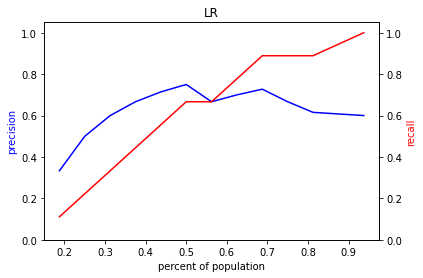

In [129]:
 plot_precision_recall_n(labels_binary[test_set_idx], y_score[:,1], 'LR')

If we examine our precision-recall curve we can see that our precision is 1 up to 40 percent of the population. We can use a "precision at *k*" curve to see what percent of the corpus can be tagged by the classifier, and which should undergo a manual clerical review. Based on this curve, we might say that we can use our classifier to tag the 25% of the documents that have the highest scores as 1, and manually review the rest. 

Alternatively, we can try to maximize the entire precision-recall space. In this case we need a different metric. 

In [130]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score[:,1])
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.632661


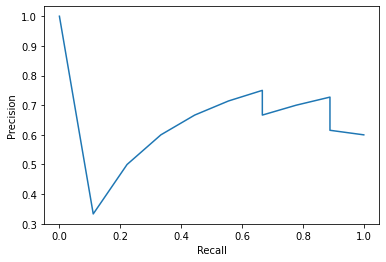

<Figure size 432x288 with 0 Axes>

In [131]:
plot_precision_recall(labels_binary[test_set_idx],y_score)

 The AUC shows how accurate our scores are under different cutoff thresholds. The model will output a score between 0 and 1. We specify a  range of cutoff values and label all of the examples as 0 or 1 based on whether they are above or below each cutoff value. The closer our scores are to the true values, the more resilient they are to different cutoffs. For instance, if our scores were perfect, our AUC would be 1. 

## Feature Importances

In [132]:
def display_feature_importances(coef,features, labels, num_features=10):
    """
    output feature importances
    
    Parameters
    ----------
    coef: numpy
        feature importances
    features: ls 
        feature names
    labels: ls
        labels for the classifier
    num_features: int
        number of features to output (default 10)
    
    Example
    --------
    
    
    """
    coef = mdl.coef_.ravel()

    dict_feature_importances = dict( zip(features, coef) )
    orddict_feature_importances = OrderedDict( 
                                    sorted(dict_feature_importances.items(), key=lambda x: x[1]) )

    ls_sorted_features  = list(orddict_feature_importances.keys())

    label0_features = ls_sorted_features[:num_features] 
    label1_features = ls_sorted_features[-num_features:] 

    print(labels[0],label0_features)
    print(labels[1], label1_features)

In [133]:
display_feature_importances(mdl.coef_.ravel(), features, ['health','income'])

health ['family focus', 'society', 'focus', 'read', 'health', 'form', 'development', 'organizations', 'programs offer', 'subscribe']
income ['employment', 'get', 'lcfs', 'lutheran', 'illinois', 'informed', 'get informed', 'informed poverty', 'youtube get', 'people']


The feature importances give us the words which are the most relevant for distinguishing the type of social service agency (between income and health). Some of these make sense ("city church" seems more likely to be health than income), but some don't make as much sense, or seem to be artifacts from the website that we should remove ("housing humancarelogo"). 

--- 

## Exercise 6 

Display the top 25 feature importances to get an intution of which words are the most and least important. 



We need to know how to pass into the function we want the top 25 feature importances. We can do this by consulting the docstring of the function. 

From this docstring we can see that `num_features` is a keyword argument that is set to 10 by default. We can pass `num_features=25` into the keyword argument instead to get the top 25 feature importances. 

In [134]:
display_feature_importances(mdl.coef_.ravel(), 
                            features,
                            ['health','income'],
                            num_features=25)

health ['family focus', 'society', 'focus', 'read', 'health', 'form', 'development', 'organizations', 'programs offer', 'subscribe', 'apologize', 'apologize inconvenience', 'centers programs', 'centerscontact', 'centerscontact usprivacy', 'communties', 'communties serve', 'coordinator subscribe', 'date family', 'development coordinator', 'different centers', 'email kelsey', 'facts family', 'fast facts', 'find seven']
income ['low', 'north', 'evanston', 'evanston north', 'ywca evanston', 'low vision', 'north shore', 'shore', 'learn', 'chicago lighthouse', 'ladder', 'lighthouse', 'ywca', 'improve', 'year', 'employment', 'get', 'lcfs', 'lutheran', 'illinois', 'informed', 'get informed', 'informed poverty', 'youtube get', 'people']


---

## Cross-validation

Recall from the machine learning tutorial that we are seeking the find the most general pattern in the data in order to have to most general model that will be successful at classifying new unseen data. Our previous strategy above was the *Out-of-sample and holdout set*. With this strategy we try to find a general pattern by randomly dividing our data into a test and training set based on some percentage split (e.g., 50-50 or 80-20). We train on the test set and evaluate on the test set, where we pretend that we don't have the labels for the test set. A significant drawback with this approach is that we may be lucky or unlucky with our random split, and so our estimate of how we'd perform on truly new data is overly optimistic or overly pessimistic. A possible solution is to create many random splits into training and testing sets and evaluate each split to estimate the performance of a given model. 

A more sophisticated holdout training and testing procedure is *cross-validation*. In cross-validation we split our data into *k* folds or partitions, where *k* is usually 5 or 10. We then iterate k times. In each iteration, one of the folds is used as a test set, and the rest of the folds are combined to form the training set. We can then evaluate the performance at each iteration to estimate the performance of a given method. An advantage of using cross-validation is all examples of data are used in the training set at least once. 


In [135]:
def create_test_train_bag_of_words(train_corpus, test_corpus):
    """
    Create test and training set bag of words
    
    
    Parameters
    ----------
    train_corpus: ls
        ls of raw text for text corpus.
    test_corpus: ls
        ls of raw text for train corpus. 
        
    Returns
    -------
    (train_bag_of_words,test_bag_of_words): scipy sparse matrix
        bag-of-words representation of train and test corpus
    features: ls
        ls of words used as features. 
    """
    #parameters for vectorizer 
    ANALYZER = "word" #unit of features are single words rather then phrases of words 
    STRIP_ACCENTS = 'unicode'
    TOKENIZER = None
    NGRAM_RANGE = (0,2) #Range for pharases of words
    MIN_DF = 0.01 # Exclude words that have a frequency less than the threshold
    MAX_DF = 0.8  # Exclude words that have a frequency greater then the threshold 

    vectorizer = CountVectorizer(analyzer=ANALYZER,
                                tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                                ngram_range=NGRAM_RANGE,
                                stop_words = stopwords.words('english'),
                                strip_accents=STRIP_ACCENTS,
                                min_df = MIN_DF,
                                max_df = MAX_DF)
    
    NORM = None #turn on normalization flag
    SMOOTH_IDF = True #prevents division by zero errors
    SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
    USE_IDF = True #flag to control whether to use TFIDF

    transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)

    #get the bag-of-words from the vectorizer and
    #then use TFIDF to limit the tokens found throughout the text 
    train_bag_of_words = vectorizer.fit_transform( train_corpus ) 
    test_bag_of_words = vectorizer.transform( test_corpus )
    if USE_IDF:
        train_tfidf = transformer.fit_transform(train_bag_of_words)
        test_tfidf = transformer.transform(test_bag_of_words)
    features = vectorizer.get_feature_names()

    
    return train_tfidf, test_tfidf, features

In [150]:
df_data = df_income_health.drop(columns = 'factype')
df_labels = df_income_health['factype']

In [152]:
df_data.columns

Index(['Unnamed: 0', 'FACID', 'facname', 'facurl', 'facloc', 'abouturl',
       'textfromurl', 'topic_id'],
      dtype='object')

In [151]:
df_labels

29     income
30     income
31     income
32     income
33     income
        ...  
101    health
102    health
103    health
104    health
105    health
Name: factype, Length: 77, dtype: object

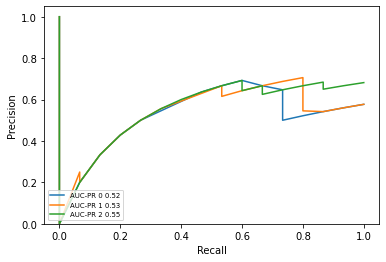

In [161]:
# from sklearn.cross_validation import StratifiedKFold
# cv = StratifiedKFold(train_labels_binary, n_folds=5)
# train_labels_binary = le.transform(train_labels)
# Original above commands are out of date as of 11/5/2021
# EY change to sklearn.model

from sklearn.model_selection import StratifiedKFold

cleaned_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_income_health.textfromurl.values])
labels = df_income_health['factype']

cv = StratifiedKFold(n_splits=3).split(cleaned_corpus, labels)

#train_labels_binary = le.transform(train_labels)
labels_binary = le.transform(labels)
for i, (train,test) in enumerate(cv):
    cv_train = cleaned_corpus[train]
    cv_test = cleaned_corpus[test]
    bag_of_words_train, bag_of_words_test, feature_names = create_test_train_bag_of_words(cv_train, 
                                                                                          cv_test)
    
    probas_ = clf.fit(bag_of_words_train, 
                      labels_binary[train]).predict_proba(bag_of_words_test)
    cv_test_labels = labels_binary[test]
    
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(cv_test_labels,
                                                                          probas_[:,1])
    auc_val = auc(recall_curve,precision_curve)
    plt.plot(recall_curve, precision_curve, label='AUC-PR {0} {1:.2f}'.format(i,auc_val))
    
plt.ylim(0,1.05)    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left", fontsize='x-small')

In this case we did 5-fold cross-validation and plotted precision-recall curves for each iteration. You can see that there is a marked difference between the iterations. We can then average the AUC-PR of each iteration to estimate the performance of our method. 

---
# Exercise 7 

Try 5-fold cross-validation. 

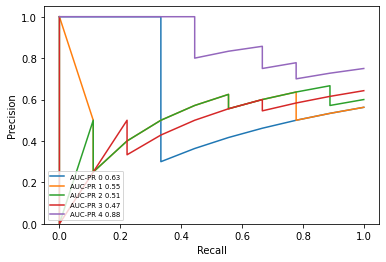

In [162]:
#from sklearn.cross_validation import StratifiedKFold
#cv = StratifiedKFold(train_labels_binary, n_folds=5)
#train_labels_binary = le.transform(train_labels)
# Original above commands are out of date as of 11/5/2021
# EY change to sklearn.model

from sklearn.model_selection import StratifiedKFold

cleaned_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_income_health.textfromurl.values])
labels = df_income_health['factype']

cv = StratifiedKFold(n_splits=5).split(cleaned_corpus, labels)

#train_labels_binary = le.transform(train_labels)
labels_binary = le.transform(labels)

for i, (train,test) in enumerate(cv):
    cv_train = cleaned_corpus[train]
    cv_test = cleaned_corpus[test]
    bag_of_words_train, bag_of_words_test, feature_names = create_test_train_bag_of_words(cv_train, 
                                                                                          cv_test)
    
    probas_ = clf.fit(bag_of_words_train, 
                      labels_binary[train]).predict_proba(bag_of_words_test)
    cv_test_labels = labels_binary[test]
    
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(cv_test_labels,
                                                                          probas_[:,1])
    auc_val = auc(recall_curve,precision_curve)
    plt.plot(recall_curve, precision_curve, label='AUC-PR {0} {1:.2f}'.format(i,auc_val))
    
plt.ylim(0,1.05)    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left", fontsize='x-small')

---

## Examples of Tagging

In [163]:
df_test

,Unnamed: 0,FACID,facname,factype,facurl,facloc,abouturl,textfromurl,topic_id
45,45,91,"Heartland Human Care Services, Inc.",income,http://www.heartlandalliance.org/,Metro,https://www.heartlandalliance.org/vision,Vision & Strategy Equity.\nOpportunity.\nFor ...,7
58,58,107,"National Able Network, Inc",income,http://www.nationalable.org/,South-Southwest Suburban,http://www.nationalable.org/about/,| Read Our Blog Read Our ...,3
89,89,152,Catholic Charities of the Archdiocese of Chicago,health,http://www.catholiccharities.net/,"Metro, North-Northwest, South-Southwest Suburban",http://www.catholiccharities.net/AboutUs.aspx,"About Us Whether They Are Young or Old, Hungry...",9
62,62,111,People’s Resource Center,income,http://www.peoplesrc.org/,West Suburban,http://www.peoplesrc.org/about-prc,Search form \nDonate Now\n \n Meeting our...,6
87,87,152,Catholic Charities of the Archdiocese of Chicago,health,http://www.catholiccharities.net/,"Metro, North-Northwest, South-Southwest Suburban",http://www.catholiccharities.net/GetHelp/OurSe...,About Us\n\n Mission Statement The mission of ...,9
76,76,135,360 Youth Services,health,http://www.360youthservices.org/,West Suburban,http://www.360youthservices.org/about-us/#what...,ABOUT US About Us What We Do 360 Youth Servic...,1
54,54,105,Lutheran Child and Family Services of Illinois,income,http://www.lcfs.org/,South-Southwest,https://www.lcfs.org/news_post/lcfs-responsibl...,"\n\t\t\t\t\t LCFS, Responsible Budget Coal...",8
99,99,166,Heartland International Health Center,health,http://www.heartlandalliance.org/,Metro,https://www.heartlandalliance.org/get-informed/,$(document).ready(function() {\n\t$('#headerbu...,5
65,65,114,Restaurant Opportunities Center of Chicago,income,http://rocunited.org/chicago/,Metro,http://rocunited.org/about-us/,ABOUT US OUR MISSION The mission of the Restau...,6
100,100,166,Heartland International Health Center,health,http://www.heartlandalliance.org/,Metro,https://www.heartlandalliance.org/about/,$(document).ready(function() {\n\t$('#headerbu...,5


In [168]:
num_comments = 2
label0_comment_idx = y_score[:,1].argsort()[:num_comments] 
label1_comment_idx = y_score[:,1].argsort()[-num_comments:]
labels = np.append(train_labels, test_labels)
test_set_labels = labels[test_set_idx]
#convert back to the indices of the original dataset
top_comments_testing_set_idx = np.concatenate([label0_comment_idx, 
                                               label1_comment_idx])


#these are the 5 comments the model is most sure of 
for i in top_comments_testing_set_idx:
    print(
        u"""{}:{}\n---\n{}\n===""".format(test_set_labels[i],
                                          y_score[i,1],
                                          test_corpus[i]))

health:1.993636686716908e-66
---
about us about us what we do   youth services provides life changing services through substance abuse prevention education counseling and housing counseling programs our counseling services are as varied as the issues that arise for those having difficulty at home school or in the community trained therapists provide a variety of professional counseling services for school aged youth and families as well as young adults educational groups for youth of all ages and their parents are also offered some issues addressed include depression anxiety grief family conflict life transitions self esteem and parenting specialized services for high risk youth are also available many insurance plans are accepted and special accommodations can be arranged for families who are struggling financially mentor programs the pressures on today s youth are greater than any other previous generation mentors work with young adults who currently live in one of   youth services h

These are the top 2 examples that the model is the most sure of for each label. We can see our important feature words in the descriptions, which gives a hint of how the model made these classifications. 

# Further Resources

A great resource for NLP in Python is 
[Natural Language Processing with Python](https://www.amazon.com/Natural-Language-Processing-Python-Analyzing/dp/0596516495).